<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Bayesian-estimation-of-a-logistic-regression-model" data-toc-modified-id="Bayesian-estimation-of-a-logistic-regression-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bayesian estimation of a logistic regression model</a></span></li><li><span><a href="#Steps-of-Bayesian-data-analysis" data-toc-modified-id="Steps-of-Bayesian-data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Steps of Bayesian data analysis</a></span></li><li><span><a href="#Step-1---Identify-the-relevant-data-for-question-under-investigation" data-toc-modified-id="Step-1---Identify-the-relevant-data-for-question-under-investigation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Step 1 - Identify the relevant data for question under investigation</a></span></li><li><span><a href="#Define-the-descriptive-statistical-model-\begin{align*}
\\y_n-&amp;\sim-Bernoulli(\alpha-+-\beta-\cdot{}-X)
\\
\alpha-&amp;\sim-Normal(0,-1.5)
\\
\beta-&amp;\sim-Normal(0,0.1)
\end{align*}" data-toc-modified-id="Define-the-descriptive-statistical-model-\begin{align*}
\\y_n-&amp;\sim-Bernoulli(\alpha-+-\beta-\cdot{}-X)
\\
\alpha-&amp;\sim-Normal(0,-1.5)
\\
\beta-&amp;\sim-Normal(0,0.1)
\end{align*}-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define the descriptive statistical model <div class="MathJax_Display MathJax_Processing"></div><script type="math/tex; mode=display" id="MathJax-Element-1">\begin{align*}
\\y_n &\sim Bernoulli(\alpha + \beta \cdot{} X)
\\
\alpha &\sim Normal(0, 1.5)
\\
\beta &\sim Normal(0,0.1)
\end{align*}</script></a></span></li><li><span><a href="#Post-model-fit-visualisations---Bayesian-simple-regression" data-toc-modified-id="Post-model-fit-visualisations---Bayesian-simple-regression-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Post model fit-visualisations - Bayesian simple regression</a></span><ul class="toc-item"><li><span><a href="#Posterior-distribution-plots" data-toc-modified-id="Posterior-distribution-plots-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Posterior distribution plots</a></span></li><li><span><a href="#Posterior--autocorrelation-plots" data-toc-modified-id="Posterior--autocorrelation-plots-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Posterior  autocorrelation plots</a></span></li></ul></li><li><span><a href="#Posterior-trace-plots" data-toc-modified-id="Posterior-trace-plots-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Posterior trace plots</a></span></li><li><span><a href="#Step-5---Posterior-predictive-checks" data-toc-modified-id="Step-5---Posterior-predictive-checks-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Step 5 - Posterior predictive checks</a></span></li><li><span><a href="#Reporting-the-results-of-the-Bayesian-logistic-regression" data-toc-modified-id="Reporting-the-results-of-the-Bayesian-logistic-regression-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Reporting the results of the Bayesian logistic regression</a></span><ul class="toc-item"><li><span><a href="#Write-up" data-toc-modified-id="Write-up-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span><font size="3">Write up</font></a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>References</a></span></li></ul></div>

In [1]:
# Import data analysis and visualisation packages
import numpy as np
import pandas as pd
import patsy as pt
import pystan as ps
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import arviz as az

In [2]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

# Bayesian estimation of a logistic regression model

To begin lets us review what logistic regression is and it applications. Gelman, Hill, Vehtari (2020)

# Steps of Bayesian data analysis

<font size = "3"> Kruscke (2015) offers a step by step formulation for how to conduct a Bayesian analysis:

1. Identify the relevant data for question under investigation.

2. Define the descriptive (mathematical) model for the data.

3. Specify the Priors for the model. In the case of scientific research publication is the goal, as such the priors must be accepted by a skeptical audience. Much of this can be achieved using prior predcitve checks to acsetain os the priors are reasonable.

4. Using Bayes rule estimate the posterior for the parameters of the model using the likelihood and priors. Then interprete and the posterior

5. Conduct model checks. i.e. Posterior predcitive checks.</font> 

<font size = "1">This notebook will follow this approach generally.</font> 

#  Step 1 - Identify the relevant data for question under investigation

The follwing data has been dowloaded from https://www.sheffield.ac.uk/mash/statistics/datasets and contatins data of mothers and their newborns. The analysis below is to use logusitc regrression to predcit the probability of being under weight (under < 6lbs) with predcitor variables.

In [9]:
# Change working directorty to import data for analysis.
url = "https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/Data/Birthweight_reduced_kg.csv"
#Import data .csv file into pandas dataframe.
df = pd.read_csv(url)

# Output data frame for evaluation
df.head(1)

,ID,Length,Birthweight,Headcirc,Gestation,smoker,mage,mnocig,mheight,mppwt,fage,fedyrs,fnocig,fheight,lowbwt,mage35
0,1360,56,4.55,34,44,0,20,0,162,57,23,10,35,179,0,0


# Define the descriptive statistical model \begin{align*}
\\y_n &\sim Bernoulli(\alpha + \beta \cdot{} X)
\\
\alpha &\sim Normal(0, 1.5)
\\
\beta &\sim Normal(0,0.1)
\end{align*}

In [16]:
logisticRegression = """

data {

  int<lower=0> N;
  int K;
  matrix[N,K] x;
  int<lower=0,upper=1> y[N];
  int<lower= 0, upper = 1> onlyprior;
  
}

parameters {
  vector[K] beta;
}

model {
// Priors
beta[1] ~ normal(0, 1.5);

for (i in 2:K){
beta[i] ~ normal(0, 1);
}

// Likelihood
 if(!onlyprior)
  y ~ bernoulli_logit(x * beta);
}

generated quantities{

//Vectorised prior/posterior checks
int yrep[N] = bernoulli_logit_rng(x * beta);

// Ouput the log odds of the estimated parameters to the probability scale (0,1) using the inverse logit function
vector[K] P_beta = inv_logit(beta);

}

"""

In [17]:
sm = ps.StanModel(model_code = logisticRegression)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_50b966c7ba5dfbb9cd25d1c28c2d1903 NOW.


In [18]:
x = pt.dmatrix(" ~ mheight ", data = df)
x = np.asarray(x)

data = {'N': len(df),
        'x': x,
        'K': 2,
        'y': df["lowbwt"].values,
        
        'onlyprior': 1}

In [19]:
fit = sm.sampling(data = data, iter = 2000, chains = 4, seed = 1, warmup = 1000)

In [20]:
# Because of python pritn stament it is easier to extract the resut sint a panda data frame for data expression
summary = fit.summary()
fit_df = pd.DataFrame(summary['summary'], 
                  columns = summary['summary_colnames'], 
                  index = summary['summary_rownames'])

In [21]:
fit_df.head(-1)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[1],0.014793,0.027465,1.495440,-3.021965,-0.987599,0.013133,1.005338,3.066676,2964.601893,1.000525
beta[2],-0.008661,0.016202,0.986690,-1.966120,-0.676512,-0.013293,0.673048,1.913142,3708.568715,1.000767
yrep[1],0.496250,0.007815,0.500048,0.000000,0.000000,0.000000,1.000000,1.000000,4093.941765,1.001387
yrep[2],0.493750,0.007846,0.500023,0.000000,0.000000,0.000000,1.000000,1.000000,4061.233713,1.001240
yrep[3],0.495250,0.007830,0.500040,0.000000,0.000000,0.000000,1.000000,1.000000,4077.865251,1.001239
yrep[4],0.495750,0.007847,0.500044,0.000000,0.000000,0.000000,1.000000,1.000000,4060.632164,1.001410
yrep[5],0.496000,0.007823,0.500047,0.000000,0.000000,0.000000,1.000000,1.000000,4085.429647,1.001232
yrep[6],0.495500,0.007847,0.500042,0.000000,0.000000,0.000000,1.000000,1.000000,4060.662657,1.001517
yrep[7],0.496000,0.007855,0.500047,0.000000,0.000000,0.000000,1.000000,1.000000,4052.222099,1.001554
yrep[8],0.496500,0.007848,0.500050,0.000000,0.000000,0.000000,1.000000,1.000000,4060.325225,1.001402


# Post model fit-visualisations - Bayesian simple regression

## Posterior distribution plots

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EF743855C8>,
      dtype=object)

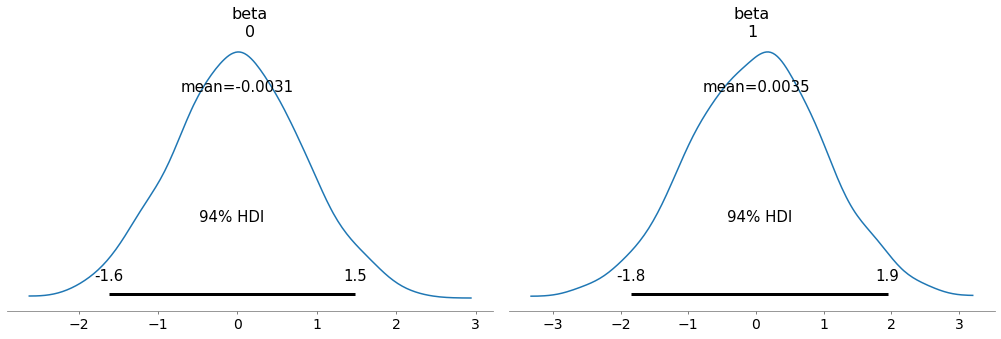

In [29]:
az.plot_posterior(fit,var_names = ('beta'));

## Posterior  autocorrelation plots

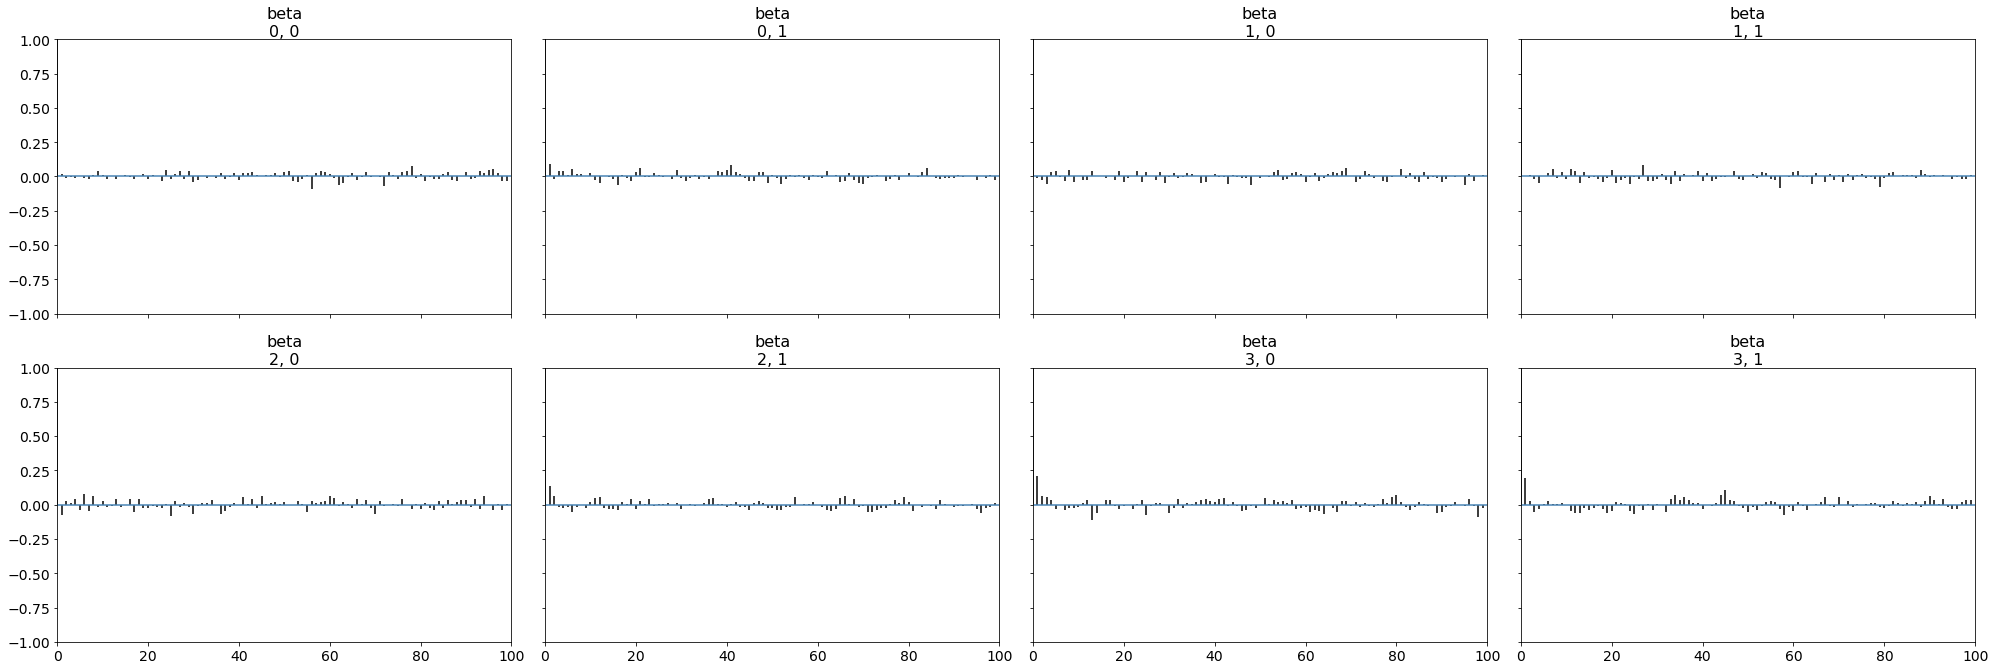

In [30]:
az.plot_autocorr(fit,var_names = ('beta'));

# Posterior trace plots 

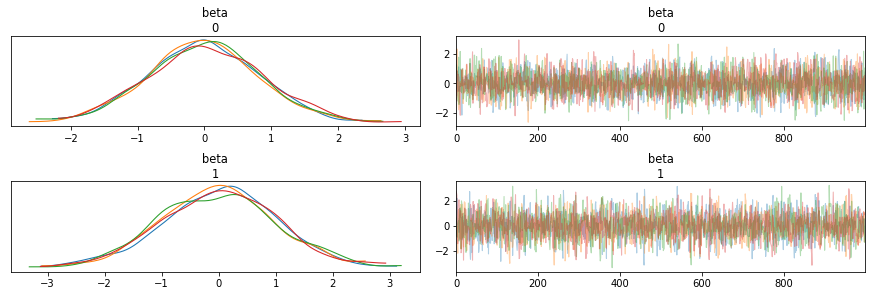

In [31]:
az.plot_trace(fit,var_names = ('beta'));

# Step 5 - Posterior predictive checks

In [22]:
#Convert pystan fit object to IO for Arviz functions.
data = az.from_pystan(
                posterior=fit,
                posterior_predictive='yrep',
                observed_data=["y"])

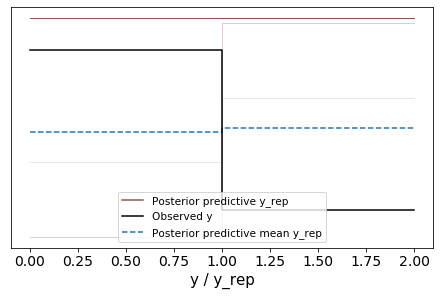

In [24]:
# Plot posterior simulated data sets for posterior predictive check
az.plot_ppc(data, data_pairs = {"y" : "yrep"}, num_pp_samples= 100);

# Reporting the results of the Bayesian logistic regression

<font size = "3">As Kruscke correctly points out there is not standard formula or presentation method for reuslts in journal article like the APA guide for reporting frequentist analysis. It is likely there never will be, because as McElreath (2020) explains, Bayesian data analysis is more like a engineering approach to the problem and the resulting model that is fit will be analysis specific. In addition, as Gabry et al, (2019) argue visualisations maybe even more key so the all the visualtions above would have to be included with any write up. Anyway below the write up as below general follows the advice of Kruscke (2015) chapter 25. In any application though it comes down to the problem to be described an the audience that needs to be convinced. </p><br/>

<h2>Write up</h2><br/>

# References

Gabry, J., Simpson, D., Vehtari, A., Betancourt, M., & Gelman, A. (2019). Visualization in Bayesian workflow. Journal of the Royal Statistical Society: Series A (Statistics in Society), 182(2), 389-402.

Gelman, A., J, Hill., A, Vehtari (2020). Regression and other stories. New york, NY: Cambridge university Press.
    
Kruschke, J. (2015). Doing Bayesian data analysis: A tutorial with R, JAGS and Stan. Oxford, England: Academic Press.    
    
McElreath, R. (2020). Statistical rethinking: A Bayesian course with examples in R and Stan. Boca Raton: CRC Press.
